# Visualize Process Masks

In [24]:
import numpy as np
import os
import matplotlib.pyplot as plt
import laspy
from ssfm.files import *
from segment_anything import sam_model_registry, SamPredictor
import torch
import cv2

In [146]:
def select_init_points_by_idx(pointcloud_path, init_prompt_idx_file, keep_idx_file, save_las_path):
    assert os.path.exists(pointcloud_path), f"Pointcloud file not found: {pointcloud_path}"
    assert os.path.exists(keep_idx_file), f"Keep idx file not found: {keep_idx_file}"
    assert os.path.exists(init_prompt_idx_file), f"Init prompt file not found: {init_prompt_idx_file}"

    with laspy.open(pointcloud_path) as las_file:
        header = las_file.header
        N_points = header.point_count
        
        pc = laspy.read(pointcloud_path)
        points = np.vstack((pc.x, pc.y, pc.z)).T
        colors = np.vstack((pc.red, pc.green, pc.blue)).T

    
    keep_idx = np.load(keep_idx_file)

    # print keep_idx.shape
    print(f"Number of selected points: {len(keep_idx)}")

    init_prompt_idx = np.load(init_prompt_idx_file)

    selected_point_idx = init_prompt_idx[keep_idx]

    select_points = points[selected_point_idx]
    select_colors = colors[selected_point_idx]


    # construct a .las file
    hdr = laspy.LasHeader(version="1.2", point_format=3)
    hdr.scale = [0.0001, 0.0001, 0.0001]  # Example scale factor, adjust as needed
    hdr.offset = np.mean(points, axis=0)

    # Create a LasData object
    las = laspy.LasData(hdr)

    # Add points
    las.x = select_points[:, 0]
    las.y = select_points[:, 1]
    las.z = select_points[:, 2]

    # Add colors
    las.red = select_colors[:, 0]
    las.green = select_colors[:, 1]
    las.blue = select_colors[:, 2]

    # Add intensity as the index of the select_points
    las.intensity = np.arange(len(select_points))

    # Write the LAS file
    las.write(save_las_path)

In [147]:
init_prompt_idx_file = '../../data/kubric_0/sampro3d/init_prompt_idx.npy'
pointcloud_path = '../../data/kubric_0/reconstructions/combined_point_cloud.las'
keep_idx_file = '../../data/kubric_0/sampro3d/keep_idx.npy'
save_las_path =  "../../data/kubric_0/sampro3d/points_from_prompt_selection.las"
select_init_points_by_idx(pointcloud_path, init_prompt_idx_file, keep_idx_file, save_las_path)

Number of selected points: 1227


In [4]:
pointcloud_path = '../../data/kubric_0/reconstructions/combined_point_cloud.las'
init_prompt_idx_file = '../../data/kubric_0/sampro3d/init_prompt_idx.npy'
selected_idx_file = '../../data/kubric_0/sampro3d/corre_3d_ins_npy/10.npy'
save_las_path = "../../data/kubric_0/sampro3d/10.las"
select_init_points_by_idx(pointcloud_path, init_prompt_idx_file, selected_idx_file, save_las_path)

Number of selected points: 114


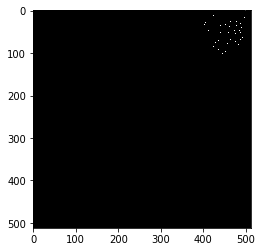

In [125]:
input_point_pos_path = "../../data/kubric_0/sampro3d/0_input_point_pos.npy"
input_point_pos = np.load(input_point_pos_path)
# create a binary mask using the input point positions
mask = np.zeros((512, 512))
mask[input_point_pos[:, 0], input_point_pos[:, 1]] = 1
plt.imshow(mask, cmap='gray')
plt.show()

In [126]:
device = torch.device('cuda:1')
sam = sam_model_registry['vit_h'](checkpoint="../../semantic_SfM/sam/sam_vit_h_4b8939.pth").to(device=device)
predictor = SamPredictor(sam)

(512, 512)


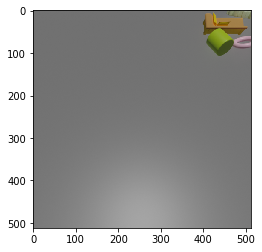

In [131]:
image_path = "../../data/kubric_0/photos/0.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
im_size = image.shape[:2]
print(im_size)
plt.imshow(image)
plt.show()
predictor.set_image(image)

In [132]:
points = torch.as_tensor(input_point_pos, device=predictor.device)
# swap x and y in points
points = points[:, [1, 0]]
transformed_points = predictor.transform.apply_coords_torch(points, im_size)
in_points = torch.as_tensor(transformed_points, device=predictor.device)
in_labels = torch.ones(in_points.shape[0], dtype=torch.int, device=in_points.device)

In [133]:
masks, iou_preds, _ = predictor.predict_torch(
    transformed_points[:,None,:],
    in_labels[:, None],
    multimask_output=False,
    return_logits=True,
)

0
5
7
15
16
21
23
25
26
29
30
40
45
47
51
52
54
55
59
63
65
66
68
69
70
76
84
86
91
95
97
107
112
117
120
121
123
136
140
144
147
149
150
151
154
161
166
167
183
186


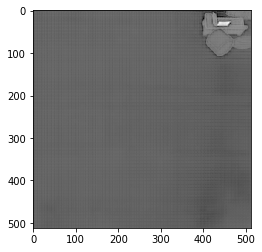

In [143]:
mask_path = '../../data/kubric_0/sampro3d/masks_npy/0.npy'
masks = np.load(mask_path)

N = len(masks)
for i in range(N):
    mask = masks[i]
    v = mask[80, 450]
    if v>0:
        print(i)

mask = masks[160]
#mask = mask[0].cpu().numpy()
plt.imshow(mask, cmap='gray')
plt.show()